In [9]:
import sys
sys.path.append('../deepsurv')
import deepsurv

#from deepsurv_logger import DeepSurvLogger, TensorboardLogger
import utils
import viz
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import lasagne
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline


In [10]:
df_final = pd.read_table("../../../analysis/clustering/clustering_Final_1/df_final_full_component_ITD.tsv",sep=" ")

eln = [1,2,3]
comp =list(range(169,193)) 
#comp_overlap = list(range(167,197))
age = [166]

all_gen = list(range(4,88))
tmp = df_final.iloc[:,all_gen][df_final.iloc[:,all_gen] >0].count()
gen = [df_final.columns.get_loc(c) for c in tmp[tmp>df_final.shape[0]*0.02].keys() if c in df_final]

all_cyto = list(range(88,158))
tmp = df_final.iloc[:,all_cyto][df_final.iloc[:,all_cyto] >0].count()
cyto = [df_final.columns.get_loc(c) for c in tmp[tmp>df_final.shape[0]*0.02].keys() if c in df_final]

clin =list(range(158,165))
demo = [165,166]
demo_without_age = [165]

eln_comp = eln + comp
eln_gen = eln + gen
eln_cyto = eln + cyto
eln_clin = eln + clin
eln_demo = eln + demo

# USEFUL FOR ELN COMPARISON
# with comp
eln_comp_gen = eln_comp + gen
eln_comp_cyto = eln_comp + cyto
eln_comp_clin = eln_comp + clin
eln_comp_demo = eln_comp + demo




eln_comp_gen_cyto = eln_comp_gen + cyto
eln_comp_gen_clin = eln_comp_gen + clin
eln_comp_gen_demo = eln_comp_gen + demo

eln_comp_cyto_clin = eln_comp_cyto + clin
eln_comp_cyto_demo = eln_comp_cyto + demo


eln_comp_clin_demo = eln_comp_clin + demo


eln_comp_gen_cyto_clin_demo = eln_comp_gen_cyto + clin + demo
eln_comp_gen_cyto_clin_demo_without_age = eln_comp_gen_cyto + clin + demo_without_age
# without comp


eln_gen_cyto = eln_gen + cyto
eln_gen_clin = eln_gen + clin
eln_gen_demo = eln_gen + demo


eln_cyto_clin = eln_cyto + clin
eln_cyto_demo = eln_cyto + demo

eln_clin_demo = eln_clin + demo
eln_clin_demo_without_age = eln_clin + demo_without_age


eln_gen_cyto_clin_demo = eln_gen_cyto + clin + demo

# USEFUL FOR COMP

comp_gen = comp + gen
comp_cyto = comp + cyto
comp_clin = comp + clin
comp_demo = comp + demo
comp_gen_cyto = comp_gen + cyto
comp_clin_demo = comp_clin + demo
comp_gen_cyto_clin_demo = comp_gen_cyto + clin + demo

#USEFUL FOR GEN
gen_cyto = gen + cyto
gen_clin = gen + clin
gen_demo = gen + demo
gen_clin_demo = gen_clin + demo
gen_cyto_clin_demo = gen_cyto + clin + demo

#USEFUL FOR CYTO 
cyto_clin = cyto + clin
cyto_demo = cyto + demo
gen_demo_without_age = gen + demo_without_age
cyto_clin_demo = cyto_clin + demo
cyto_gen_demo = gen_cyto + demo


clin_demo  = clin + demo

In [11]:
train_df = df_final.iloc[:,eln_comp+[193,194]]
train,test = train_test_split(train_df,test_size=0.2,random_state=17)
train,val = train_test_split(train,test_size=0.2,random_state=17)

In [12]:
def dataframe_to_deepsurv_ds(df, event_col = 'os_status', time_col = 'os'):
    # Extract the event and time columns as numpy arrays
    e = df[event_col].values.astype(np.int32)
    t = df[time_col].values.astype(np.float32)

    # Extract the patient's covariates as a numpy array
    x_df = df.drop([event_col, time_col], axis = 1)
    x = x_df.values.astype(np.float32)
    #x=x_df
    
    # Return the deep surv dataframe
    return {
        'x' : x,
        'e' : e,
        't' : t
    }


In [13]:
### Min Max Scaler Normalization and good format of the data to feed the MLP network
scale = preprocessing.MinMaxScaler().fit(train)
df_train = pd.DataFrame(scale.transform(train.values), columns=train.columns, index=train.index)
df_val = pd.DataFrame(scale.transform(val.values), columns=val.columns, index=val.index)
df_test = pd.DataFrame(scale.transform(test.values), columns=test.columns, index=test.index)
train_data = dataframe_to_deepsurv_ds(df_train, event_col = 'os_status', time_col= 'os')
val_data = dataframe_to_deepsurv_ds(df_val, event_col = 'os_status', time_col= 'os')
test_data = dataframe_to_deepsurv_ds(df_test, event_col = 'os_status', time_col= 'os')

/Users/taziy/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [21]:
hyperparams = {
    'L2_reg': 10.0,
    'batch_norm': True,
    'dropout': 0.4,
    'hidden_layers_sizes': [25,25],
    'learning_rate': 1e-05,
    'lr_decay': 0.001,
    'momentum': 0.9,
    'n_in': train_data['x'].shape[1],
    'activation':'selu'

    #'standardize': True
}
hyperparams = {'n_in': train_data['x'].shape[1],
 'learning_rate': 1e-05,
 'hidden_layers_sizes': [100, 500, 10],
 'lr_decay': 0.001,
 'momentum': 0.9,
 'L2_reg': 10.0,
 'L1_reg': 0.0,
 'activation': 'rectify',
 'dropout': 0.4,
 'batch_norm': True,
 'standardize': False}
np.random.seed(17)
network = deepsurv.DeepSurv(**hyperparams)
network.restored_update_params = None 
logger = deepsurv.deepsurv_logger.TensorboardLogger(name = 'DeepSurvLogger', logdir = './logs/tensorboard/')
np.random.seed(17)
update_fn=lasagne.updates.nesterov_momentum # The type of optimizer to use. 
#update_fn=lasagne.updates.rmsprop
n_epochs = 12000
val_frequency=500
patience=10000 # minimum number of epochs to train for
metrics =  network.train(train_data,val_data, n_epochs=n_epochs, logger=logger, update_fn=update_fn,patience=patience,validation_frequency=val_frequency)

2019-08-27 11:45:06,966 - Training step 0/12000     |                         | - loss: 28.2233 - ci: 0.5732


KeyboardInterrupt: 

# after this training evaluate concordance index and get parameters when concordance index is maximal on validation set then test on testing dataset.

In [15]:
hid_layers=[[100,100],[100,100,10],[100,500,10],[25,100,10],[500,100,100],[500,100]]*4+[[100,25]]
l2_reg=[10.0]*12+[1.0]*12+[10.0]
act=(['rectify']*6+['selu']*6)*2+['selu']
network=[None]*25
metrics=[None]*25
df_tmp = pd.DataFrame(columns=('train_C_index','val_C_index','test_C_index', 'hyperparams'))
for i in range(25):

    hyperparams = {
        'L2_reg': l2_reg[i],
        'batch_norm': True,
        'dropout': 0.4,
        'hidden_layers_sizes': hid_layers[i],
        'learning_rate': 1e-05,
        'lr_decay': 0.001,
        'momentum': 0.9,
        'n_in': train_data['x'].shape[1],
        'activation':act[i]
        #'standardize': True
    }
    np.random.seed(17)
    network[i] = deepsurv.DeepSurv(**hyperparams)
    network[i].restored_update_params = None 
    logger = deepsurv.deepsurv_logger.TensorboardLogger(name = 'DeepSurvLogger', logdir = './logs/tensorboard/')
    np.random.seed(17)
    #update_fn=lasagne.updates.nesterov_momentum # The type of optimizer to use. 
    update_fn=lasagne.updates.rmsprop
#     n_epochs = 20000
    n_epochs =5000
    val_frequency=250
    patience=10000 # minimum number of epochs to train for
    metrics[i] =  network[i].train(train_data,val_data, n_epochs=n_epochs, logger=logger, update_fn=update_fn,patience=patience,validation_frequency=val_frequency)
    print (network[i].get_concordance_index(x=test_data['x'],t=test_data['t'],e=test_data['e']))
    df_tmp.loc[i] = [network[i].get_concordance_index(x=train_data['x'],t=train_data['t'],e=train_data['e']),network[i].get_concordance_index(x=val_data['x'],t=val_data['t'],e=val_data['e']),network[i].get_concordance_index(x=test_data['x'],t=test_data['t'],e=test_data['e']),network[i].hyperparams]

2019-08-27 14:18:50,862 - Training step 0/250   |                         | - loss: 23.3993 - ci: 0.4805
2019-08-27 14:18:50,862 - Training step 0/250   |                         | - loss: 23.3993 - ci: 0.4805
2019-08-27 14:19:15,332 - Finished Training with 250 iterations in 24.67s
2019-08-27 14:19:15,332 - Finished Training with 250 iterations in 24.67s
2019-08-27 14:19:17,342 - Training step 0/250   |                         | - loss: 24.3028 - ci: 0.5301
2019-08-27 14:19:17,342 - Training step 0/250   |                         | - loss: 24.3028 - ci: 0.5301
2019-08-27 14:19:17,342 - Training step 0/250   |                         | - loss: 24.3028 - ci: 0.5301
2019-08-27 14:19:42,578 - Finished Training with 250 iterations in 25.43s
2019-08-27 14:19:42,578 - Finished Training with 250 iterations in 25.43s
2019-08-27 14:19:42,578 - Finished Training with 250 iterations in 25.43s


In [ ]:
import sys
sys.path.append('/juno/work/isabl/opt/python/.virtualenvs/users/taziy/theano/lib/python3.6/site-packages/deepsurv/')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import ShuffleSplit, GridSearchCV,train_test_split
from sklearn.model_selection import cross_validate

from sksurv.datasets import load_veterans_lung_cancer
from sksurv.column import encode_categorical
from sksurv.metrics import concordance_index_censored
from sksurv.svm import FastSurvivalSVM,FastKernelSurvivalSVM
from sksurv.kernels import clinical_kernel
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def score_survival_model(model, X, y):
    prediction = model.predict(X)
    result = concordance_index_censored(y['Status'], y['Survival_in_days'], prediction)
    return result[0]
    
    
df_final = pd.read_table("../../../analysis/clustering/clustering_Final_1/df_final_full_component_ITD.tsv",sep=" ")

eln = [1,2,3]
comp =list(range(169,193)) 
#comp_overlap = list(range(167,197))
age = [166]

all_gen = list(range(4,88))
tmp = df_final.iloc[:,all_gen][df_final.iloc[:,all_gen] >0].count()
gen = [df_final.columns.get_loc(c) for c in tmp[tmp>df_final.shape[0]*0.02].keys() if c in df_final]

all_cyto = list(range(88,158))
tmp = df_final.iloc[:,all_cyto][df_final.iloc[:,all_cyto] >0].count()
cyto = [df_final.columns.get_loc(c) for c in tmp[tmp>df_final.shape[0]*0.02].keys() if c in df_final]

clin =list(range(158,165))
demo = [165,166]
demo_without_age = [165]

eln_comp = eln + comp
eln_gen = eln + gen
eln_cyto = eln + cyto
eln_clin = eln + clin
eln_demo = eln + demo

# USEFUL FOR ELN COMPARISON
# with comp
eln_comp_gen = eln_comp + gen
eln_comp_cyto = eln_comp + cyto
eln_comp_clin = eln_comp + clin
eln_comp_demo = eln_comp + demo




eln_comp_gen_cyto = eln_comp_gen + cyto
eln_comp_gen_clin = eln_comp_gen + clin
eln_comp_gen_demo = eln_comp_gen + demo

eln_comp_cyto_clin = eln_comp_cyto + clin
eln_comp_cyto_demo = eln_comp_cyto + demo


eln_comp_clin_demo = eln_comp_clin + demo


eln_comp_gen_cyto_clin_demo = eln_comp_gen_cyto + clin + demo
eln_comp_gen_cyto_clin_demo_without_age = eln_comp_gen_cyto + clin + demo_without_age
# without comp


eln_gen_cyto = eln_gen + cyto
eln_gen_clin = eln_gen + clin
eln_gen_demo = eln_gen + demo


eln_cyto_clin = eln_cyto + clin
eln_cyto_demo = eln_cyto + demo

eln_clin_demo = eln_clin + demo
eln_clin_demo_without_age = eln_clin + demo_without_age


eln_gen_cyto_clin_demo = eln_gen_cyto + clin + demo

# USEFUL FOR COMP

comp_gen = comp + gen
comp_cyto = comp + cyto
comp_clin = comp + clin
comp_demo = comp + demo
comp_gen_cyto = comp_gen + cyto
comp_clin_demo = comp_clin + demo
comp_gen_cyto_clin_demo = comp_gen_cyto + clin + demo

#USEFUL FOR GEN
gen_cyto = gen + cyto
gen_clin = gen + clin
gen_demo = gen + demo
gen_clin_demo = gen_clin + demo
gen_cyto_clin_demo = gen_cyto + clin + demo

#USEFUL FOR CYTO 
cyto_clin = cyto + clin
cyto_demo = cyto + demo
gen_demo_without_age = gen + demo_without_age
cyto_clin_demo = cyto_clin + demo
cyto_gen_demo = gen_cyto + demo


clin_demo  = clin + demo

train_df = df_final.iloc[:,eln_comp+[193,194]]
train,test = train_test_split(train_df,test_size=0.2,random_state=17)
train,val = train_test_split(train,test_size=0.2,random_state=17)

def dataframe_to_deepsurv_ds(df, event_col = 'os_status', time_col = 'os'):
    # Extract the event and time columns as numpy arrays
    e = df[event_col].values.astype(np.int32)
    t = df[time_col].values.astype(np.float32)

    # Extract the patient's covariates as a numpy array
    x_df = df.drop([event_col, time_col], axis = 1)
    x = x_df.values.astype(np.float32)
    #x=x_df
    
    # Return the deep surv dataframe
    return {
        'x' : x,
        'e' : e,
        't' : t
    }
scale = preprocessing.MinMaxScaler().fit(train)
df_train = pd.DataFrame(scale.transform(train.values), columns=train.columns, index=train.index)
df_val = pd.DataFrame(scale.transform(val.values), columns=val.columns, index=val.index)
df_test = pd.DataFrame(scale.transform(test.values), columns=test.columns, index=test.index)
train_data = dataframe_to_deepsurv_ds(df_train, event_col = 'os_status', time_col= 'os')
val_data = dataframe_to_deepsurv_ds(df_val, event_col = 'os_status', time_col= 'os')
test_data = dataframe_to_deepsurv_ds(df_test, event_col = 'os_status', time_col= 'os')

hid_layers=[[100,100],[100,100,10],[100,500,10],[25,100,10],[500,100,100],[500,100]]*4+[[100,25]]
l2_reg=[10.0]*12+[1.0]*12+[10.0]
act=(['rectify']*6+['selu']*6)*2+['selu']
network=[None]*25
metrics=[None]*25
df_tmp = pd.DataFrame(columns=('train_C_index','val_C_index','test_C_index', 'hyperparams'))
for i in range(25):

    hyperparams = {
        'L2_reg': l2_reg[i],
        'batch_norm': True,
        'dropout': 0.4,
        'hidden_layers_sizes': hid_layers[i],
        'learning_rate': 1e-05,
        'lr_decay': 0.001,
        'momentum': 0.9,
        'n_in': train_data['x'].shape[1],
        'activation':act[i]
        #'standardize': True
    }
    np.random.seed(17)
    network[i] = deepsurv.DeepSurv(**hyperparams)
    network[i].restored_update_params = None 
    logger = deepsurv.deepsurv_logger.TensorboardLogger(name = 'DeepSurvLogger', logdir = './logs/tensorboard/')
    np.random.seed(17)
    #update_fn=lasagne.updates.nesterov_momentum # The type of optimizer to use. 
    update_fn=lasagne.updates.rmsprop
#     n_epochs = 20000
    n_epochs =5000
    val_frequency=250
    patience=10000 # minimum number of epochs to train for
    metrics[i] =  network[i].train(train_data,val_data, n_epochs=n_epochs, logger=logger, update_fn=update_fn,patience=patience,validation_frequency=val_frequency)
    print (network[i].get_concordance_index(x=test_data['x'],t=test_data['t'],e=test_data['e']))
    df_tmp.loc[i] = [network[i].get_concordance_index(x=train_data['x'],t=train_data['t'],e=train_data['e']),network[i].get_concordance_index(x=val_data['x'],t=val_data['t'],e=val_data['e']),network[i].get_concordance_index(x=test_data['x'],t=test_data['t'],e=test_data['e']),network[i].hyperparams]
    
df_tmp.to_csv("tmp.csv")

In [143]:
for i in range(25):
    print (network[i].get_concordance_index(x=val_data['x'],t=val_data['t'],e=val_data['e']),network[i].get_concordance_index(x=test_data['x'],t=test_data['t'],e=test_data['e']),network[i].hyperparams)

0.7496196912641213 0.7774745123223891 {'n_in': 178, 'learning_rate': 1e-05, 'hidden_layers_sizes': [100, 100], 'lr_decay': 0.001, 'momentum': 0.9, 'L2_reg': 10.0, 'L1_reg': 0.0, 'activation': 'rectify', 'dropout': 0.4, 'batch_norm': True, 'standardize': False}
0.7495199381530712 0.7838805490888657 {'n_in': 178, 'learning_rate': 1e-05, 'hidden_layers_sizes': [100, 100, 10], 'lr_decay': 0.001, 'momentum': 0.9, 'L2_reg': 10.0, 'L1_reg': 0.0, 'activation': 'rectify', 'dropout': 0.4, 'batch_norm': True, 'standardize': False}
0.7598443851467618 0.7704904872762303 {'n_in': 178, 'learning_rate': 1e-05, 'hidden_layers_sizes': [100, 500, 10], 'lr_decay': 0.001, 'momentum': 0.9, 'L2_reg': 10.0, 'L1_reg': 0.0, 'activation': 'rectify', 'dropout': 0.4, 'batch_norm': True, 'standardize': False}
0.744457467767276 0.7749859516737577 {'n_in': 178, 'learning_rate': 1e-05, 'hidden_layers_sizes': [25, 100, 10], 'lr_decay': 0.001, 'momentum': 0.9, 'L2_reg': 10.0, 'L1_reg': 0.0, 'activation': 'rectify', 'dro

In [145]:
network[2].hyperparams

{'n_in': 178,
 'learning_rate': 1e-05,
 'hidden_layers_sizes': [100, 500, 10],
 'lr_decay': 0.001,
 'momentum': 0.9,
 'L2_reg': 10.0,
 'L1_reg': 0.0,
 'activation': 'rectify',
 'dropout': 0.4,
 'batch_norm': True,
 'standardize': False}

In [ ]:
hid=[[100,500,50],[100,500,30],[100,500,20],[100,500,10]]*2
drop=[0.2,0.2,0.2,0,2,0,4,0.4,0.4,0.4,0.4]
network_bis=[None]*2
metrics_bis=[None]*2
for i in range(8):
    hyperparams = {
    'L2_reg': 10.0,
    'batch_norm': True,
    'dropout': 0.4,
    'hidden_layers_sizes': hid[i],
    'learning_rate': 1e-05,
    'lr_decay': 0.001,
    'momentum': 0.9,
    'n_in': train_data['x'].shape[1],
    'activation':'rectify'

    #'standardize': True
}
    np.random.seed(17)
    network_bis[i] = deepsurv.DeepSurv(**hyperparams)
    network_bis[i].restored_update_params = None 
    logger = deepsurv.deepsurv_logger.TensorboardLogger(name = 'DeepSurvLogger', logdir = './logs/tensorboard/')
    np.random.seed(17)
    update_fn=lasagne.updates.rmsprop
    #update_fn=lasagne.updates.rmsprop
    n_epochs = 20000
    val_frequency=250
    patience=10000 # minimum number of epochs to train for
    metrics_bis[i] =  network_bis[i].train(train_data,val_data, n_epochs=n_epochs, logger=logger, update_fn=update_fn,patience=patience,validation_frequency=val_frequency)

In [155]:
network_bis[0].get_concordance_index(x=val_data['x'],t=val_data['t'],e=val_data['e']),network_bis[i].get_concordance_index(x=test_data['x'],t=test_data['t'],e=test_data['e']),network_bis[0].hyperparams


IndexError: list index out of range

In [214]:
network.save_model("deep_surv_model_500_epochs", weights_file ="deep_surv_weights_500_epochs")
previous_model = deepsurv.deep_surv.load_model_from_json(model_fp = 'deep_surv_model_500_epochs' , weights_fp =     'deep_surv_weights_500_epochs')
previous_model.get_concordance_index(x=val_data['x'],t=val_data['t'],e=val_data['e'])

Loading json model: {"n_in": 178, "learning_rate": 1e-05, "hidden_layers_sizes": [100, 10], "lr_decay": 0.001, "momentum": 0.9, "L2_reg": 10.0, "L1_reg": 0.0, "activation": "rectify", "dropout": 0.4, "batch_norm": true, "standardize": false}


0.44322067913622865

In [216]:
metrics['valid_c-index']

[(0, 0.4391265954884804), (250, 0.4491450590029702)]

In [217]:
metrics['best_valid_loss']

array(10.96796368)

Train C-Index: (499, 0.4681709875707654)


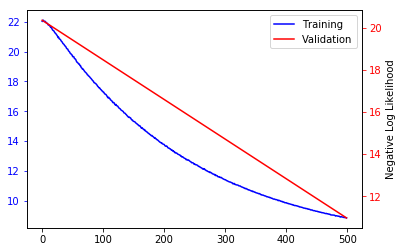

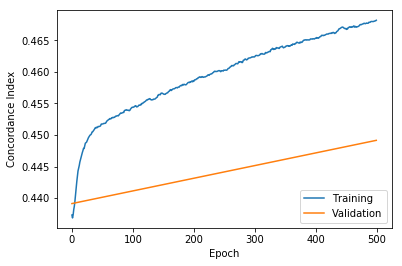

In [218]:

# Print the final metrics
print('Train C-Index:', metrics['c-index'][-1])
# print('Valid C-Index: ',metrics['valid_c-index'][-1])

# Plot the training / validation curves
deepsurv.viz.plot_log(metrics)

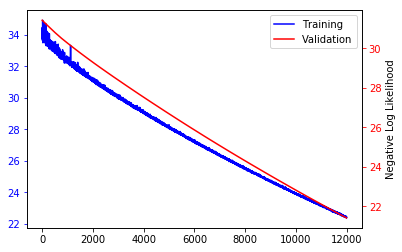

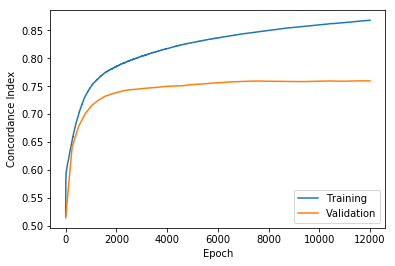

In [144]:
deepsurv.viz.plot_log(metrics[2])